# Notebook 3: Data Mining Techniques
### DSA 2040A Group Project - Lung Cancer Data Analysis
### Team Members: Calvin, Tanveer, Samantha, Patricia, Susan and Arlen

#### Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


from sklearn.pipeline import Pipeline

# Scikit-learn for data mining
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
)
# Set plot style
sns.set_style("whitegrid")
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For saving/loading models
import joblib


# Section 1: Load Cleaned Data

In [68]:
CLEANED_DATA = '../data/transformed_data.csv' 
MODEL_SAVE_PATH = '../models/survival_predictor.pkl' 


df = pd.read_csv(CLEANED_DATA)
print(f"Cleaned data loaded successfully from {CLEANED_DATA}")

#[Tanveer] Convert relevant columns to their appropriate types after loading from CSV
if 'diagnosis_date' in df.columns:
    df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')
if 'end_treatment_date' in df.columns:
    df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'], errors='coerce')

#[Tanveer] Convert string object columns to 'category' dtype for better memory usage and explicit handling
categorical_cols_to_convert = ['gender', 'country', 'cancer_stage', 'smoking_status',
                                'treatment_type', 'age_group', 'bmi_category', 'cholesterol_category']
for col in categorical_cols_to_convert:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype('category')
#[Calvin] convert to 1 and 0(pseudo one hot encoding)
if 'family_history' in df.columns and df['family_history'].dtype == 'object':
        df['family_history'] = df['family_history'].map({'Yes': 1, 'No': 0}).astype(int)
if 'survived' in df.columns and df['survived'].dtype != 'int64':
        df['survived'] = df['survived'].astype(int)

print("\nFirst 5 rows of cleaned data:")
print(df.head())
print("\nCleaned Data Info:")
df.info()


Cleaned data loaded successfully from ../data/transformed_data.csv

First 5 rows of cleaned data:
       id   age  gender  country diagnosis_date cancer_stage  family_history  \
0  278120  63.0  Female  Hungary     2024-04-01    Stage III               0   
1  100970  54.0  Female  Croatia     2021-08-14     Stage IV               1   
2  684392  60.0    Male   Latvia     2023-01-22    Stage III               0   
3  746694  55.0  Female  Hungary     2020-08-04    Stage III               0   
4  566016  46.0    Male    Spain     2024-01-03      Stage I               1   

   smoking_status   bmi  cholesterol_level  ...  treatment_duration  \
0  Passive Smoker  22.2                162  ...                 618   
1    Never Smoked  36.2                258  ...                 486   
2  Passive Smoker  18.7                195  ...                 418   
3    Never Smoked  28.8                161  ...                 280   
4  Current Smoker  37.3                257  ...                 48

## 2. Data preprocessing
- We are going to define target variabels and features
- Filter out redundant columns
- identify numerical and categorical features for preprocessing
- 

In [69]:
from sklearn.pipeline import Pipeline

#[Calvin] Define target variable and features
TARGET = 'survived'
#[Calvin] Drop 
columns_to_drop = [TARGET, 'diagnosis_date', 'end_treatment_date', 'index', 'comorbidity_count']
#[Samantha] Filter out columns that do not exist in the DataFrame
columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=columns_to_drop_existing)
y = df[TARGET]

#[Arlen] Identify numerical and categorical features for preprocessing
numerical_features = ['treatment_duration', 'comorbidities_count']
#[Arlen] Filter numerical_features to ensure they exist in X
numerical_features = [f for f in numerical_features if f in X.columns]

#[Suezan] All original categorical columns that need one hot encoding
categorical_features = ['gender', 'country', 'cancer_stage', 'smoking_status',
                        'treatment_type', 'age_group', 'bmi_category', 'cholesterol_category']
#[Suezan] Filter categorical_features to ensure they exist in X
categorical_features = [f for f in categorical_features if f in X.columns]

print(f"\nFeatures selected for modeling: {X.columns.tolist()}")
print(f"Numerical Features for scaling: {numerical_features}")
print(f"Categorical Features for One-Hot Encoding: {categorical_features}")

#[Patricia] Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)



Features selected for modeling: ['id', 'age', 'gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type', 'treatment_duration', 'comorbidities_count', 'age_group', 'bmi_category', 'cholesterol_category', 'diagnosis_year', 'diagnosis_month', 'diagnosis_quarter', 'diagnosis_year_month']
Numerical Features for scaling: ['treatment_duration', 'comorbidities_count']
Categorical Features for One-Hot Encoding: ['gender', 'country', 'cancer_stage', 'smoking_status', 'treatment_type', 'age_group', 'bmi_category', 'cholesterol_category']


## 3. Model Selection and Training

#### Experimenting with different models

#### Data Splitting


In [70]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures the same proportion of classes in train and test sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 7051 samples
Testing set size: 1763 samples


### Logistic Regression


--- Logistic Regression Evaluation ---
Accuracy: 0.7805
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.5000

--- Confusion Matrix ---


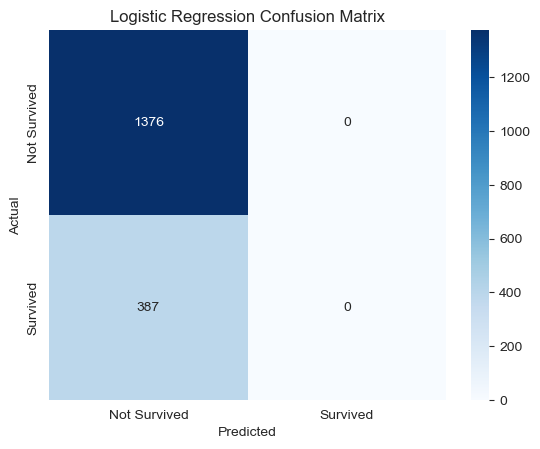


--- ROC Curve ---


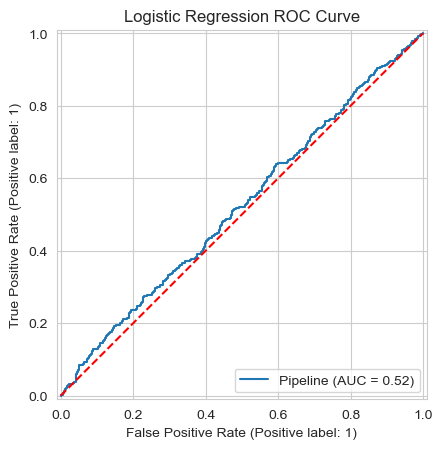

In [71]:
# Drop 'diagnosis_year_month' from train and test features if present
if 'diagnosis_year_month' in X_train.columns:
    X_train_lr = X_train.drop(columns=['diagnosis_year_month'])
else:
    X_train_lr = X_train

if 'diagnosis_year_month' in X_test.columns:
    X_test_lr = X_test.drop(columns=['diagnosis_year_month'])
else:
    X_test_lr = X_test

# Create the pipeline with preprocessor and classifier
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model
pipeline_lr.fit(X_train_lr, y_train)

# Make predictions on the test set
y_pred_lr = pipeline_lr.predict(X_test)

# --- Output and Visualization ---

# 1. Print Classification Metrics
print("--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lr):.4f}\n")

# 2. Plot Confusion Matrix
print("--- Confusion Matrix ---")
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# 3. Plot ROC Curve
print("\n--- ROC Curve ---")
RocCurveDisplay.from_estimator(pipeline_lr, X_test, y_test)
plt.title('Logistic Regression ROC Curve')
plt.plot([0, 1], [0, 1], 'r--') # Dashed diagonal
plt.show()

#### Random Forest Classifier

--- Random Forest Evaluation ---
Accuracy: 0.7799
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.4996

--- Confusion Matrix ---


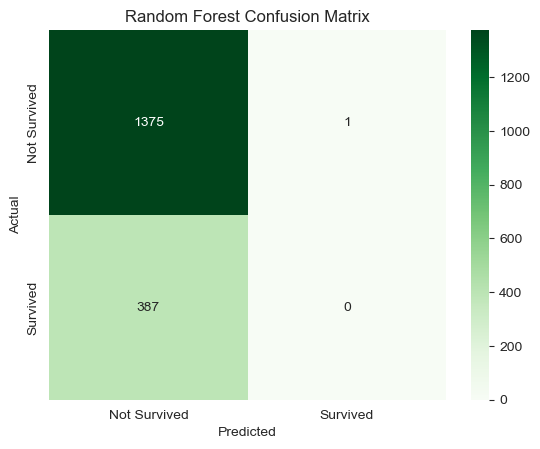


--- Feature Importances ---
Length mismatch: importances=68, feature_names=56


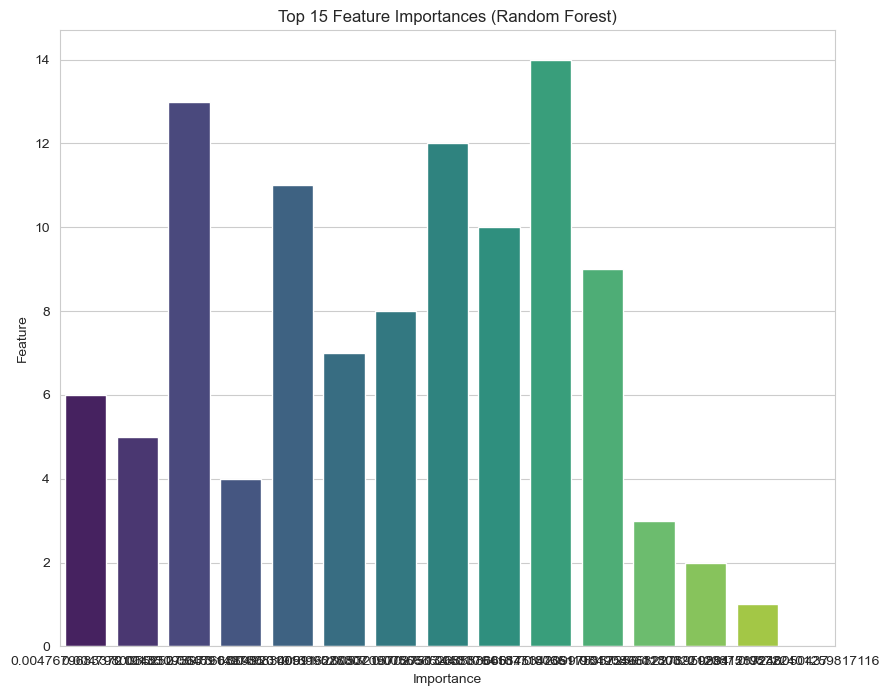

In [72]:
# Drop 'diagnosis_year_month' from train and test features if present
if 'diagnosis_year_month' in X_train.columns:
    X_train_rf = X_train.drop(columns=['diagnosis_year_month'])
else:
    X_train_rf = X_train

if 'diagnosis_year_month' in X_test.columns:
    X_test_rf = X_test.drop(columns=['diagnosis_year_month'])
else:
    X_test_rf = X_test

# Create the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Train the model
pipeline_rf.fit(X_train_rf, y_train)

# Make predictions on the test set
y_pred_rf = pipeline_rf.predict(X_test_rf)


# Print Classification Metrics
print("--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf):.4f}\n")

# Plot Confusion Matrix
print("--- Confusion Matrix ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Plot Feature Importances
print("\n--- Feature Importances ---")
# Get feature importances from the fitted Random Forest model
importances = pipeline_rf.named_steps['classifier'].feature_importances_

# Get feature names from the preprocessor
num_features = numerical_features
cat_features = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(num_features) + list(cat_features)

# Ensure lengths match
if len(importances) == len(all_feature_names):
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
else:
    print(f"Length mismatch: importances={len(importances)}, feature_names={len(all_feature_names)}")
    feature_importance_df = pd.DataFrame({'feature': range(len(importances)), 'importance': importances})

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Model Comparison

In [73]:
print("--- Model Performance Comparison ---")
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "F1-Score": [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf)],
    "ROC-AUC": [roc_auc_score(y_test, y_pred_lr), roc_auc_score(y_test, y_pred_rf)]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)


--- Model Performance Comparison ---
                 Model  F1-Score   ROC-AUC
0  Logistic Regression       0.0  0.500000
1        Random Forest       0.0  0.499637


# 5 - fold cross-validation

In [75]:
# Drop 'diagnosis_year_month' from X if present
if 'diagnosis_year_month' in X.columns:
	X_rf_cv = X.drop(columns=['diagnosis_year_month'])
else:
	X_rf_cv = X

cv_scores = cross_val_score(pipeline_rf, X_rf_cv, y, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation ROC-AUC scores: [0.48709837 0.50976598 0.55456215 0.55141762 0.5200203 ]
Mean ROC-AUC: 0.5246 (+/- 0.0511)


# Hyperparameter Tuning
Let's improve our Random Forest model by finding the optimal hyperparameters using GridSearchCV.

In [77]:
# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

print("Starting grid search...")

# Drop 'diagnosis_year_month' from X_train and X_test if present
if 'diagnosis_year_month' in X_train.columns:
    X_train_rf_gs = X_train.drop(columns=['diagnosis_year_month'])
else:
    X_train_rf_gs = X_train

# Fit GridSearchCV
grid_search.fit(X_train_rf_gs, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation ROC-AUC score: {:.4f}".format(grid_search.best_score_))

# Use the best model for predictions
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("\n--- Best Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_best_rf):.4f}")

Starting grid search...

Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation ROC-AUC score: 0.5234

--- Best Model Evaluation ---
Accuracy: 0.7805
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.5000


### Saving the Best Model

In [79]:
import os

# Ensure the models directory exists
os.makedirs('../models', exist_ok=True)

# Save the best model (Random Forest with optimized hyperparameters)
joblib.dump(best_rf, '../models/survival_predictor.pkl')
print("Best model saved successfully!")

# To demonstrate how to load and use the model:
loaded_model = joblib.load('../models/survival_predictor.pkl')
print("\nModel loaded successfully!")
print("Verification - ROC-AUC score with loaded model:", 
      roc_auc_score(y_test, loaded_model.predict(X_test)))

Best model saved successfully!

Model loaded successfully!
Verification - ROC-AUC score with loaded model: 0.5
